# Learning epsilon - Bounded Confidence
### Asynchronous 

In this notebook we estimate the bounded interval epsilon by minimizing the negative log likelihood with different estimation procedures:
- scipy.optimize
- torch, compare different optimizers and learning rates

In [1]:
import sys
sys.path += ['../src/']
import simulator_BC as sim_bc
import estimation_epsilon_BC as est_bc
import numpy as np
import torch
import torch.optim as optim
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from tqdm import tqdm
from scipy.special import logit, expit

In [22]:
importlib.reload(sim_bc)
importlib.reload(est_bc)

<module 'estimation_epsilon_BC' from '/home/jacopo.lenti/Projects/learning-od-step-by-step/notebook/../src/estimation_epsilon_BC.py'>

### Create edges and opinions dataset

- epsilon is the real value of the bounded confidence.
- mu is the convergence parameter.
- min_d and max_d, are respectively the minum distance at which two nodes did not interact, and the maximum distance at which two nodes interacted. If the estimation is in the interval [max_d, min_d], it is correct, because all the edges are predicted correct.

In [3]:
N, T, edge_per_t = 100, 200, 10
epsilon, mu = 0.31, 0.1
seed = 9


X, edges = sim_bc.simulator(N, T, edge_per_t, epsilon, mu, seed)

In [4]:
max_d, min_d = sim_bc.max_min_interaction_distance(edges, X)

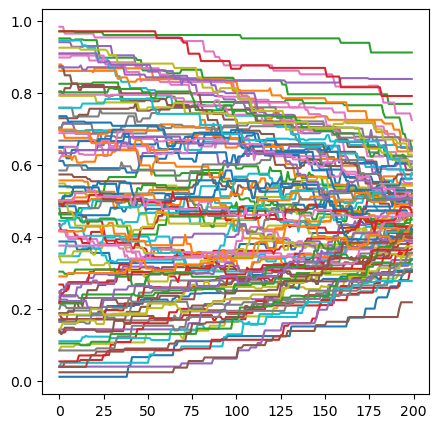

In [5]:
sim_bc.print_opinion_trajectory(X)

In [6]:
epsilon, max_d, min_d

(0.31, 0.30975492596632936, 0.310464221363318)

### Estimation with scipy and torch

- rho is the steepness of the sigmoid function for computing the probability of interaction.
- epsilon0 is the initialization of the optimizer.

In [7]:
rho = 100
epsilon0 = 0.24

In [8]:
epsilon_scipy = est_bc.estimation_epsilon_scipy(rho, X, edges, epsilon0)

In [9]:
history_torch = est_bc.estimation_epsilon_torch(rho, mu, X, edges, epsilon0, 
                                                num_epochs = 2000)

epsilon_torch = history_torch["epsilon"][-1]

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2939.65it/s]


In [10]:
epsilon_scipy, epsilon_torch, epsilon, max_d, min_d

(0.31165595560581,
 0.3116559606066376,
 0.31,
 0.30975492596632936,
 0.310464221363318)

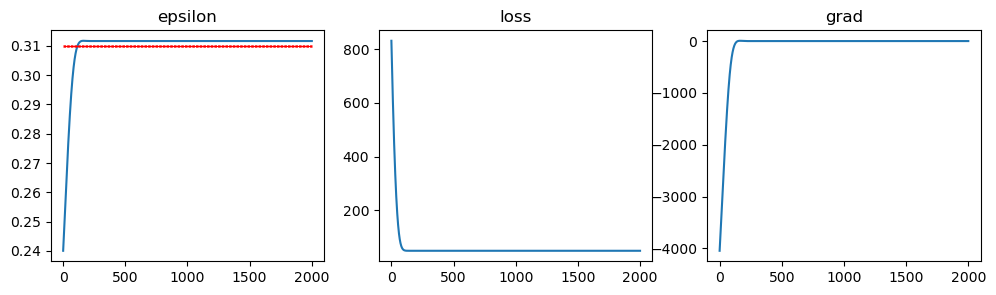

In [11]:
est_bc.print_history(history_torch, epsilon, max_d = max_d, min_d = min_d)

### Batch Norm

In [12]:
N, T, edge_per_t = 200, 1000, 5
epsilon, mu = 0.45, 0.2
seed = 9


X, edges = sim_bc.simulator(N, T, edge_per_t, epsilon, mu, seed)

In [17]:
t0 = time()
history_torch_batch0 = est_bc.estimation_epsilon_torch(rho, mu, X, edges, epsilon0, num_epochs = 2000, batch_size = 0)
t1 = time()
history_torch_batch50 = est_bc.estimation_epsilon_torch(rho, mu, X, edges, epsilon0, num_epochs = 2000, batch_size = 50)
t2 = time()
history_torch_batch100 = est_bc.estimation_epsilon_torch(rho, mu, X, edges, epsilon0, num_epochs = 2000, batch_size = 100)
t3 = time()
history_torch_batch200 = est_bc.estimation_epsilon_torch(rho, mu, X, edges, epsilon0, num_epochs = 2000, batch_size = 200)
t4 = time()
history_torch_batch1000 = est_bc.estimation_epsilon_torch(rho, mu, X, edges, epsilon0, num_epochs = 2000, batch_size = 1000)
t5 = time()


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2658.31it/s]


In [18]:
print(f"Time without batch: {round(t1 - t0, 2)}s")
print(f"Time with batch 10: {round(t2 - t1, 2)}s")
print(f"Time with batch 20: {round(t3 - t2, 2)}s")
print(f"Time with batch 50: {round(t4 - t3, 2)}s")

Time without batch: 0.93s
Time with batch 10: 0.71s
Time with batch 20: 0.74s
Time with batch 50: 0.76s


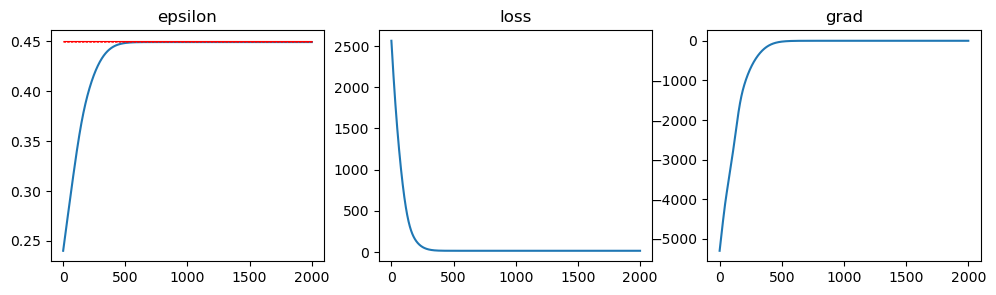

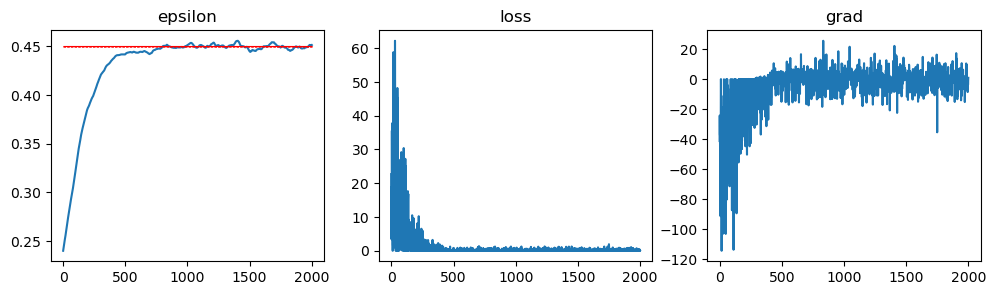

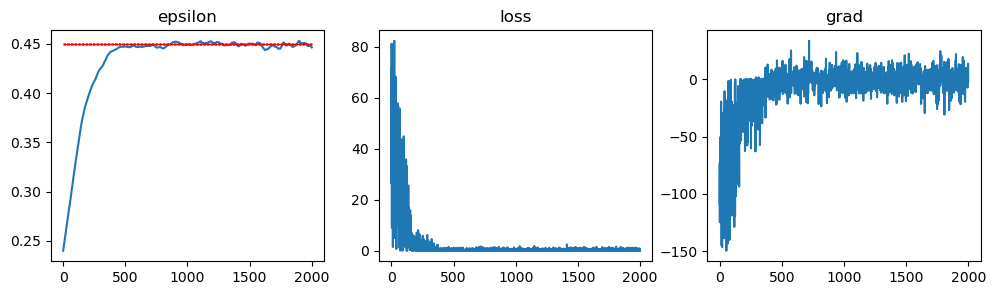

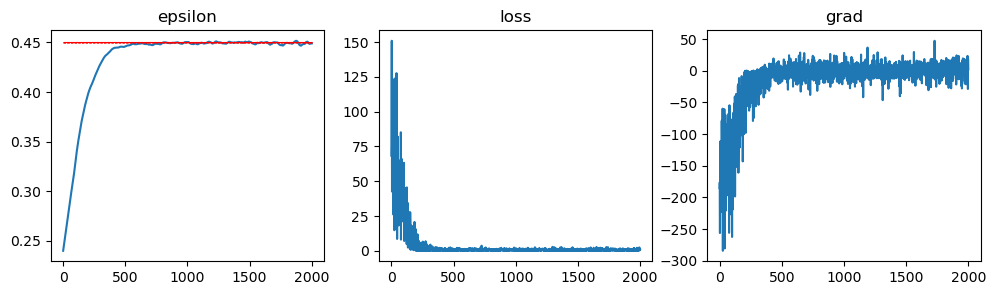

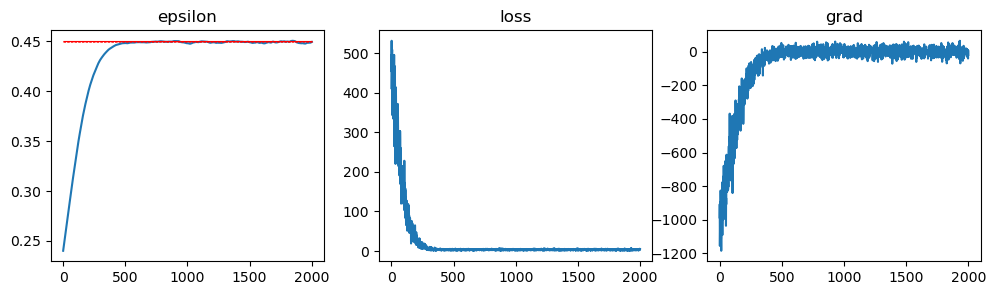

In [19]:
max_d, min_d = sim_bc.max_min_interaction_distance(edges, X)
est_bc.print_history(history_torch_batch0, epsilon, max_d = max_d, min_d = min_d)
est_bc.print_history(history_torch_batch50, epsilon, max_d = max_d, min_d = min_d)
est_bc.print_history(history_torch_batch100, epsilon, max_d = max_d, min_d = min_d)
est_bc.print_history(history_torch_batch200, epsilon, max_d = max_d, min_d = min_d)
est_bc.print_history(history_torch_batch1000, epsilon, max_d = max_d, min_d = min_d)

### Loss function
Compare the loss function for different realization with same value of epsilon.

In [20]:
N, T, edge_per_t = 200, 400, 10
epsilon, mu = 0.11, 0.1
seed = 9


X, edges = sim_bc.simulator(N, T, edge_per_t, epsilon, mu, seed)

In [23]:
losses = est_bc.losses_closure(edges, X, rho, epsilon_values = np.arange(0,1,0.01))

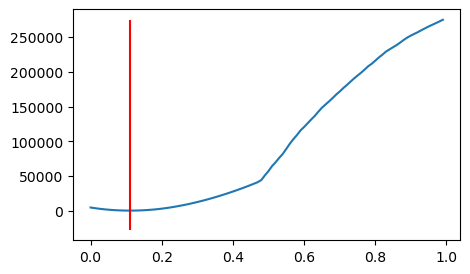

In [24]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,3))

#for seed in range(100):
#    X, edges, max_dist, min_dist = simulator(N, T, x0, edge_per_t, epsilon, mu, seed = seed)

ax.plot(losses[0], losses[1])
ax.vlines(epsilon, ymin = -np.max(losses) / 10, ymax = np.max(losses), color = "red")


Refer to the notebook 1.1_continuity_analysis_loss for the analysis of the plot.

### Different optimizer
Compare the estimation of epsilon for the same trajectory with different optimizer.

In [25]:
np.random.seed(22)
epsilon, mu, epsilon0 = np.random.random(3)

In [26]:
N, T, edge_per_t = 100, 200, 10

In [27]:
X, edges = sim_bc.simulator(N, T, edge_per_t, epsilon, mu, seed = 345) 

max_d, min_d = sim_bc.max_min_interaction_distance(edges, X)

In [28]:
history_adam = est_bc.estimation_epsilon_torch(rho, mu, X, edges, epsilon0, 
                                               num_epochs = 500, optimizer_name = "adam",
                                               lr = 0.01, forward = "epsilon")
history_adagrad = est_bc.estimation_epsilon_torch(rho, mu, X, edges, epsilon0, 
                                               num_epochs = 500, optimizer_name = "adagrad",
                                               lr = 0.01, forward = "epsilon")
history_nadam = est_bc.estimation_epsilon_torch(rho, mu, X, edges, epsilon0, 
                                               num_epochs = 500, optimizer_name = "nadam",
                                               lr = 0.01, forward = "epsilon")
history_SGD = est_bc.estimation_epsilon_torch(rho, mu, X, edges, epsilon0, 
                                               num_epochs = 500, optimizer_name = "SGD",
                                               lr = 0.0000005, forward = "epsilon")

100%|███████████████████████████████████████| 500/500 [00:00<00:00, 3414.17it/s]


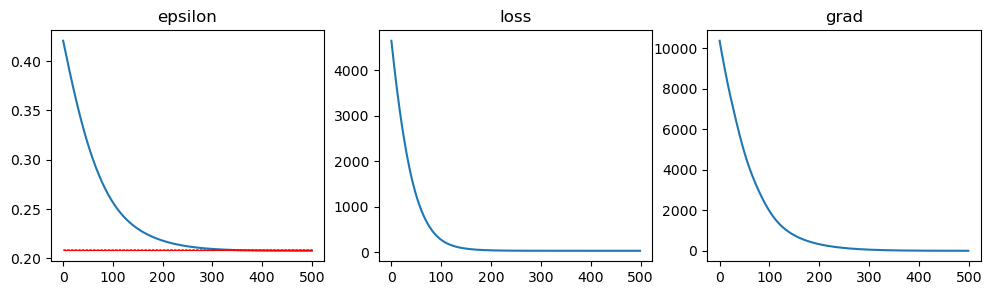

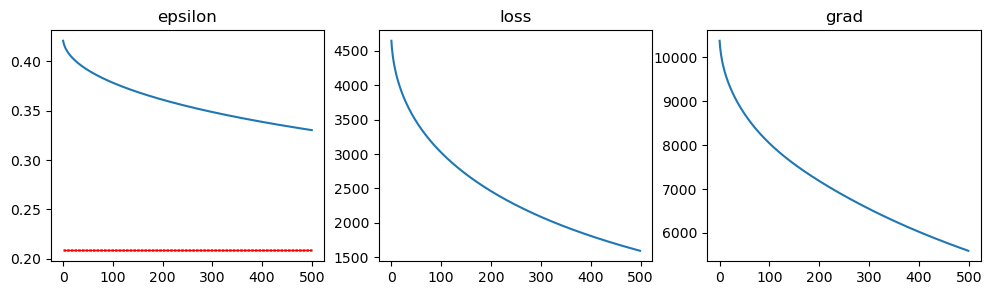

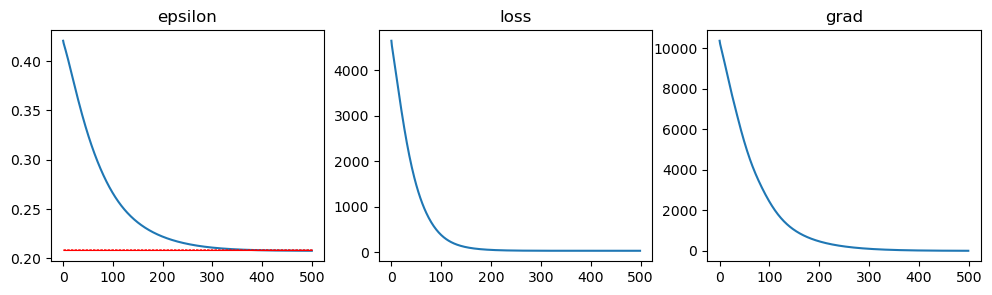

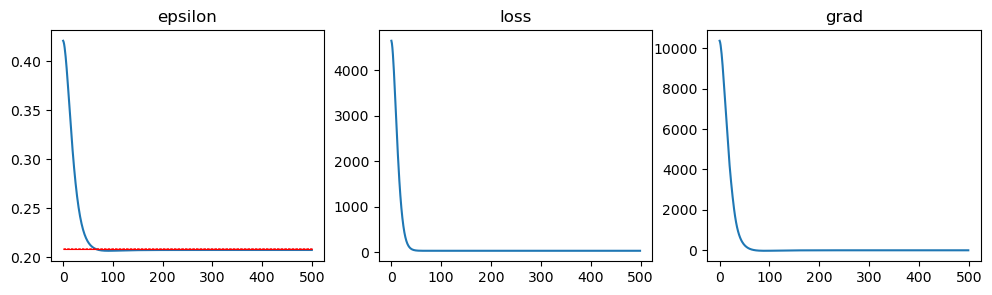

In [29]:
est_bc.print_history(history_adam, epsilon, max_d = max_d, min_d = min_d)
est_bc.print_history(history_adagrad, epsilon, max_d = max_d, min_d = min_d)
est_bc.print_history(history_nadam, epsilon, max_d = max_d, min_d = min_d)
est_bc.print_history(history_SGD, epsilon, max_d = max_d, min_d = min_d)

In [59]:
torch.sum(edges[:,:,2])

tensor(905)

### Repeated estimations
Repeat the estimation with different optimizers, learning rates and different parameters.

In [60]:
def repeat_estimation(N, T, edge_per_t, optimizers = ["adam", "nadam", "adagrad", "SGD"], 
                      learning_rates = [0.1,0.01,0.001, 0.0001], num_epochs = 1000, rhos = [10, 100, 1000],
                      repetitions = 10, scipy = True, hide_progress = True):
    output = []
    
    for _ in tqdm(range(repetitions)):
        while True:
            epsilon, mu, epsilon0 = np.random.random(3)
            X, edges = sim_bc.simulator(N, T, edge_per_t, epsilon, mu)
            if torch.sum(edges[:,:,2]) * (torch.sum(1 - edges[:,:,2])) != 0:
                break
        max_d, min_d = sim_bc.max_min_interaction_distance(edges, X)
        
        for optimizer in optimizers:
            for lr in learning_rates:
                if optimizer == "SGD":
                    lr = lr / 10000
                for rho in rhos:
                    t0 = time()
                    history = est_bc.estimation_epsilon_torch(rho, mu, X, edges, epsilon0, 
                                                              num_epochs = num_epochs, optimizer_name = optimizer,
                                                              lr = lr, forward = "epsilon", hide_progress = hide_progress)
                    t1 = time()
                    output.append({"real_epsilon": epsilon, "max_d": max_d, "min_d": min_d, "epsilon0": epsilon0, 
                                   "estimated_epsilon_100_epochs": history["epsilon"][100], "estimated_epsilon_200_epochs": history["epsilon"][200],
                                   "estimated_epsilon_500_epochs": history["epsilon"][500], "estimated_epsilon_1000_epochs": history["epsilon"][1000],
                                   "max_epsilon": max(history["epsilon"]),
                                   "min_epsilon": min(history["epsilon"]), "rho": rho, "lr": lr, "mu": mu, "optimizer": optimizer,
                                   "time": t1 - t0
                                  })
        if scipy:
            t0 = time()
            epsilon_scipy = est_bc.estimation_epsilon_scipy(rho, X, edges, epsilon0)
            t1 = time()
            
            output.append({"real_epsilon": epsilon, "max_d": max_d, "min_d": min_d, "epsilon0": epsilon0, 
                           "estimated_epsilon_100_epochs": epsilon_scipy, "estimated_epsilon_200_epochs": epsilon_scipy,
                           "estimated_epsilon_500_epochs": epsilon_scipy, "estimated_epsilon_1000_epochs": epsilon_scipy,
                           "max_epsilon": epsilon_scipy,
                           "min_epsilon": epsilon_scipy, "rho": rho, "lr": None, "mu": mu, "optimizer": "scipy",
                           "time": t1 - t0
                          })
    return pd.DataFrame(output)


In [75]:
N, T, edge_per_t = 100, 100, 4

estimations_optimizers = repeat_estimation(N, T, edge_per_t, optimizers = ["adam", "nadam", "adagrad", "SGD"], 
                                           learning_rates = [0.1, 0.01, 0.001, 0.0001], 
                                           num_epochs = 1000, rhos = [10, 100, 1000],
                                           repetitions = 20, scipy = True, hide_progress = True)

100%|███████████████████████████████████████████| 20/20 [05:59<00:00, 17.95s/it]


In [76]:
estimations_optimizers["right_interval"] = estimations_optimizers.apply(lambda x: (x["estimated_epsilon_1000_epochs"] < x["min_d"])&(x["estimated_epsilon_1000_epochs"] > x["max_d"]), axis = 1)


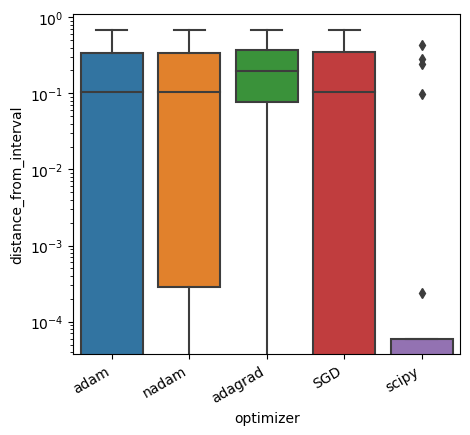

In [79]:
estimations_optimizers = estimations_optimizers.assign(distance_from_min = lambda x: np.abs(x["estimated_epsilon_100_epochs"] - x["min_d"]),
                                                       distance_from_max = lambda x: np.abs(x["estimated_epsilon_100_epochs"] - x["max_d"]))

estimations_optimizers["distance_from_interval"] = [min(estimations_optimizers.distance_from_max[k], estimations_optimizers.distance_from_min[k]) for k in range(len(estimations_optimizers))] * (1 - estimations_optimizers["right_interval"])


fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(data = estimations_optimizers,
            x = "optimizer", y = "distance_from_interval")

#sns.scatterplot(data = estimations_optimizers.assign(distance_from_exact = lambda x: np.abs(x["estimated_epsilon_1000_epochs"] - x["real_epsilon"])), 
#                x = "lr", y = "distance_from_exact", hue = "optimizer")

#lims = [max(1, 1), min(0, 0)]
#ax.plot(lims, lims, '-r')

#ax.set_xlim([0,0.5])
#ax.set_ylim([0,0.5])
#ax.set_xscale("log")
ax.set_yscale("log")

fig.autofmt_xdate()

/tmp/ipykernel_3428181/811271270.py:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim([0, 1])


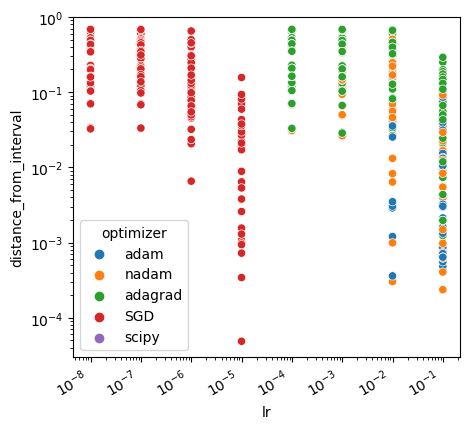

In [80]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data = estimations_optimizers, x = "lr", y = "distance_from_interval", hue = "optimizer")

#lims = [max(1, 1), min(0, 0)]
#ax.plot(lims, lims, '-r')

#ax.set_xlim([0,0.5])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([0, 1])

fig.autofmt_xdate()